In [1]:
import jax
import jax.numpy as jnp
from jax import vmap, jit, lax

L = 1.0

def neohookean_elasticity_model_3d(ux, uy, uz, mu=1.0, lam=1.0):
    """
    Compute the stress tensor for a linear isotropic material in 3D (misnamed as Neo-Hookean in original).
    This is actually linear elasticity. For true Neo-Hookean, use the nonlinear functions below.
    Parameters:
    ux, uy, uz (jnp.ndarray): displacement components.
    mu (float): Shear modulus.
    lam (float): First Lamé parameter.
    Returns:
    jnp.ndarray: Stress tensor components [sxx, syy, szz, sxy, sxz, syz].
    """
    # Assuming structured grid, use finite differences for gradients
    # Note: For FEM, strains are computed per element, but here for grid example
    eps_xx = jnp.gradient(ux, axis=0)
    eps_yy = jnp.gradient(uy, axis=1)
    eps_zz = jnp.gradient(uz, axis=2)
    eps_xy = 0.5 * (jnp.gradient(ux, axis=1) + jnp.gradient(uy, axis=0))
    eps_xz = 0.5 * (jnp.gradient(ux, axis=2) + jnp.gradient(uz, axis=0))
    eps_yz = 0.5 * (jnp.gradient(uy, axis=2) + jnp.gradient(uz, axis=1))
    sxx = 2 * mu * eps_xx + lam * (eps_xx + eps_yy + eps_zz)
    syy = 2 * mu * eps_yy + lam * (eps_xx + eps_yy + eps_zz)
    szz = 2 * mu * eps_zz + lam * (eps_xx + eps_yy + eps_zz)
    sxy = 2 * mu * eps_xy
    sxz = 2 * mu * eps_xz
    syz = 2 * mu * eps_yz
    return sxx, syy, szz, sxy, sxz, syz

def isotropic_invariants(I1, I3, mu, lam):
    return (mu / 2) * (I1 - jnp.log(I3) - 3) + (lam / 8) * (jnp.log(I3) ** 2)

@jit
def precompute(rest_pos, tet_indices, young=1e6, poisson=0.45):
    tet_pos = rest_pos[tet_indices]  # (n_tets, 4, 3)
    X_il = tet_pos[:, 0] - tet_pos[:, 3]
    X_jl = tet_pos[:, 1] - tet_pos[:, 3]
    X_kl = tet_pos[:, 2] - tet_pos[:, 3]
    Dm = jnp.stack([X_il, X_jl, X_kl], axis=-1)  # (n_tets, 3, 3)
    det_Dm = jnp.linalg.det(Dm)
    volumes = jnp.abs(det_Dm) / 6.0
    # Remove runtime check for invalid tets to allow JIT
    # Assume mesh is valid (positive orientation and volume)
    B_matrices = jnp.linalg.inv(Dm)  # (n_tets, 3, 3)
    return B_matrices, volumes

@jit
def compute_first_piola_kirchhoff(F, mu, lam):
    J = jnp.linalg.det(F)
    F_invT = jnp.linalg.inv(F).transpose((0, 2, 1))
    P = mu * (F - F_invT) + lam * jnp.log(J)[:, None, None] * F_invT
    return P

@jit
def compute_elastic_forces(displacements, rest_pos, tet_indices, B_matrices, volumes, young=1e6, poisson=0.45):
    n_nodes = rest_pos.shape[0]
    n_tets = tet_indices.shape[0]
    mu = young / (2 * (1 + poisson))
    lam = young * poisson / ((1 + poisson) * (1 - 2 * poisson))
    tet_disps = displacements[tet_indices]  # (n_tets, 4, 3)
    u_il = tet_disps[:, 0] - tet_disps[:, 3]
    u_jl = tet_disps[:, 1] - tet_disps[:, 3]
    u_kl = tet_disps[:, 2] - tet_disps[:, 3]
    Ds = jnp.stack([u_il, u_jl, u_kl], axis=-1)  # (n_tets, 3, 3)
    F = jnp.matmul(Ds, B_matrices)  # (n_tets, 3, 3)
    P = compute_first_piola_kirchhoff(F, mu, lam)
    Bt = B_matrices.transpose((0, 2, 1))
    H = -volumes[:, None, None] * jnp.matmul(P, Bt)  # (n_tets, 3, 3)
    forces = jnp.zeros((n_nodes, 3))
    # Accumulate forces for nodes i, j, k, l
    forces = forces.at[tet_indices[:, 0]].add(H[:, :, 0])
    forces = forces.at[tet_indices[:, 1]].add(H[:, :, 1])
    forces = forces.at[tet_indices[:, 2]].add(H[:, :, 2])
    forces = forces.at[tet_indices[:, 3]].add(-jnp.sum(H, axis=1))
    return forces

@jit
def compute_stress_strain(displacements, rest_pos, tet_indices, B_matrices, volumes, young=1e6, poisson=0.45):
    mu = young / (2 * (1 + poisson))
    lam = young * poisson / ((1 + poisson) * (1 - 2 * poisson))
    tet_disps = displacements[tet_indices]  # (n_tets, 4, 3)
    u_il = tet_disps[:, 0] - tet_disps[:, 3]
    u_jl = tet_disps[:, 1] - tet_disps[:, 3]
    u_kl = tet_disps[:, 2] - tet_disps[:, 3]
    Ds = jnp.stack([u_il, u_jl, u_kl], axis=-1)  # (n_tets, 3, 3)
    F = jnp.matmul(Ds, B_matrices)  # (n_tets, 3, 3)
    C = jnp.matmul(F.transpose((0, 2, 1)), F)
    I = jnp.eye(3)
    E = 0.5 * (C - I[None, :, :])  # Green-Lagrange strain (n_tets, 3, 3)
    J = jnp.linalg.det(F)
    P = compute_first_piola_kirchhoff(F, mu, lam)
    sigma = (1 / J[:, None, None]) * jnp.matmul(P, F.transpose((0, 2, 1)))  # Cauchy stress (n_tets, 3, 3)
    return E, sigma

def generate_simple_tet_mesh(grid_size=2, L=1.0):
    """
    Generate a simple 3D cubic grid divided into 5 tetrahedra per cube (consistent orientation).
    """
    nx, ny, nz = grid_size, grid_size, grid_size
    x = jnp.linspace(0, L, nx)
    y = jnp.linspace(0, L, ny)
    z = jnp.linspace(0, L, nz)
    X, Y, Z = jnp.meshgrid(x, y, z, indexing='ij')
    rest_pos = jnp.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=-1)
    tet = []
    for ix in range(nx - 1):
        for jy in range(ny - 1):
            for kz in range(nz - 1):
                p000 = ix + nx * (jy + ny * kz)
                p100 = (ix + 1) + nx * (jy + ny * kz)
                p010 = ix + nx * ((jy + 1) + ny * kz)
                p110 = (ix + 1) + nx * ((jy + 1) + ny * kz)
                p001 = ix + nx * (jy + ny * (kz + 1))
                p101 = (ix + 1) + nx * (jy + ny * (kz + 1))
                p011 = ix + nx * ((jy + 1) + ny * (kz + 1))
                p111 = (ix + 1) + nx * ((jy + 1) + ny * (kz + 1))
                # Use a fixed splitting pattern for consistent positive orientation
                tet.extend([
                    [p000, p100, p010, p111],
                    [p100, p010, p110, p111],
                    [p100, p110, p101, p111],
                    [p010, p110, p011, p111],
                    [p001, p010, p011, p101]
                ])
    tet_indices = jnp.array(tet, dtype=jnp.int32)
    return rest_pos, tet_indices

if __name__ == "__main__":
    # Example usage for 3D tetrahedral mesh
    rest_pos, tet_indices = generate_simple_tet_mesh(grid_size=3, L=1.0)
    
    # Optional: check volumes outside JIT if needed
    # temp_Dm = ... compute det_Dm as in precompute
    # if jnp.any(det_Dm <= 0): raise ...
    
    B_matrices, volumes = precompute(rest_pos, tet_indices)
    # Sample displacement: stretch in x
    displacements = 0.1 * rest_pos  # Simple example
    forces = compute_elastic_forces(displacements, rest_pos, tet_indices, B_matrices, volumes)
    strains, stresses = compute_stress_strain(displacements, rest_pos, tet_indices, B_matrices, volumes)
    print("Forces shape:", forces.shape)
    print("Sample force at node 0:", forces[0])
    print("Average Cauchy stress (xx component):", jnp.mean(stresses[..., 0, 0]))

Forces shape: (27, 3)
Sample force at node 0: [ 9.074684e+06 -9.074684e+06 -9.074684e+06]
Average Cauchy stress (xx component): nan


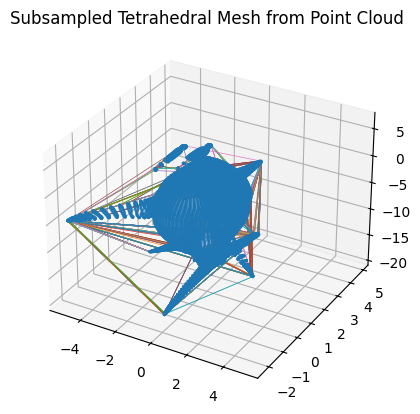

In [81]:
# Optimized visualization: subsample tetrahedra for speed
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

obj_path = "base_megalodon.obj"
points = []
with open(obj_path, "r") as f:
    for line in f:
        if line.startswith("v "):
            _, x, y, z = line.split()
            points.append([float(x), float(y), float(z)])
points = np.array(points)

tet = Delaunay(points)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

max_tets = min(500, len(tet.simplices))
edges = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]

for simplex in tet.simplices[:max_tets]:
    tetra = points[simplex]
    for i, j in edges:
        ax.plot(
            [tetra[i,0], tetra[j,0]],
            [tetra[i,1], tetra[j,1]],
            [tetra[i,2], tetra[j,2]],
            linewidth=0.5
        )

ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
ax.set_title("Subsampled Tetrahedral Mesh from Point Cloud")
plt.show()

Total tets: 2343383
Closed tets kept: 2298388


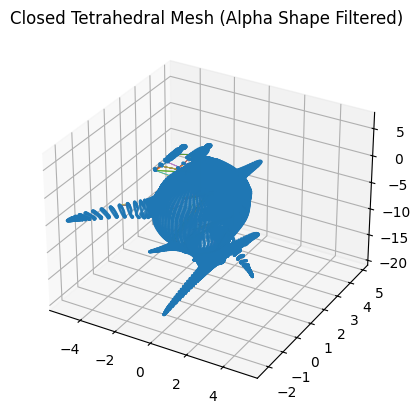

In [82]:
# Closed tetrahedral mesh generation using Alpha Shape filtering + visualization
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# -------------------------------------------------
# 1. Load point cloud from OBJ
# -------------------------------------------------
obj_path = "base_megalodon.obj"
points = []
with open(obj_path, "r") as f:
    for line in f:
        if line.startswith("v "):
            _, x, y, z = line.split()
            points.append([float(x), float(y), float(z)])
points = np.array(points)

# -------------------------------------------------
# 2. Delaunay tetrahedralization
# -------------------------------------------------
deln = Delaunay(points)
simplices = deln.simplices

# -------------------------------------------------
# 3. Alpha-shape filtering (remove exterior tets)
# -------------------------------------------------
def circumsphere_radius(pts):
    A = np.hstack((2 * (pts - pts[0]), np.ones((4, 1))))
    b = np.sum(pts**2 - pts[0]**2, axis=1)
    try:
        x = np.linalg.lstsq(A, b, rcond=None)[0]
        center = x[:3]
        return np.linalg.norm(center - pts[0])
    except:
        return np.inf

alpha = np.percentile(
    [circumsphere_radius(points[s]) for s in simplices[:2000]], 60
)

mask = []
for s in simplices:
    r = circumsphere_radius(points[s])
    mask.append(r < alpha)

mask = np.array(mask)
closed_tets = simplices[mask]

print(f"Total tets: {len(simplices)}")
print(f"Closed tets kept: {len(closed_tets)}")

# -------------------------------------------------
# 4. Visualization (subsampled)
# -------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

edges = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
max_vis = min(400, len(closed_tets))

for tet in closed_tets[:max_vis]:
    P = points[tet]
    for i, j in edges:
        ax.plot(
            [P[i,0], P[j,0]],
            [P[i,1], P[j,1]],
            [P[i,2], P[j,2]],
            linewidth=0.5
        )

ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
ax.set_title("Closed Tetrahedral Mesh (Alpha Shape Filtered)")
plt.show()

# -------------------------------------------------
# 5. Save tetrahedral mesh
# -------------------------------------------------
np.savez(
    "megalodon_closed_tetmesh.npz",
    points=points,
    tets=closed_tets
)

#### Taubin Smoothing
The Taubin Smoothing is a iterative technique used in boundary-smoothings of Veronoi triangulation in $\mathscr{P} \in \mathbb{R}^3$ with no $\textbf{volume contractions}$, where the Taubin $\lambda$-$\mu$ is given by
$$
\begin{align*}
V^{k+\frac{1}{2}} = V^k + \lambda \Delta V^k\\
V^{k+1} = V^{k+\frac{1}{2}} + \mu \Delta V^{k+\frac{1}{2}}
\end{align*}
$$
$\lambda > 0$ (Contraction), $\mu < 0$ (Inverse Expansion)

In [83]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# =============================
# Load mesh
# =============================
data = np.load("megalodon_closed_tetmesh.npz")
V = data["points"]
T = data["tets"]

# =============================
# Extract boundary faces
# =============================
face_count = defaultdict(int)
for tet in T:
    faces = [
        tuple(sorted(tet[[0,1,2]])),
        tuple(sorted(tet[[0,1,3]])),
        tuple(sorted(tet[[0,2,3]])),
        tuple(sorted(tet[[1,2,3]])),
    ]
    for f in faces:
        face_count[f] += 1

boundary_faces = np.array([f for f,c in face_count.items() if c == 1])
boundary_vertices = np.unique(boundary_faces)

# =============================
# Adjacency (surface graph)
# =============================
adj = defaultdict(list)
for i,j,k in boundary_faces:
    adj[i] += [j,k]
    adj[j] += [i,k]
    adj[k] += [i,j]

for v in adj:
    adj[v] = list(set(adj[v]))

# =============================
# Taubin smoothing (SAFE params)
# =============================
def taubin(V, adj, verts, iters=6, lam=0.45, mu=-0.48):
    Vn = V.copy()
    for _ in range(iters):
        L = np.zeros_like(Vn)
        for i in verts:
            nei = adj[i]
            L[i] = np.mean(Vn[nei], axis=0) - Vn[i]
        Vn += lam * L

        L[:] = 0.0
        for i in verts:
            nei = adj[i]
            L[i] = np.mean(Vn[nei], axis=0) - Vn[i]
        Vn += mu * L
    return Vn

V_smooth = taubin(V, adj, boundary_vertices)

np.savez(
    "megalodon_closed_tetmesh_taubin.npz",
    points=V_smooth,
    tets=T
)

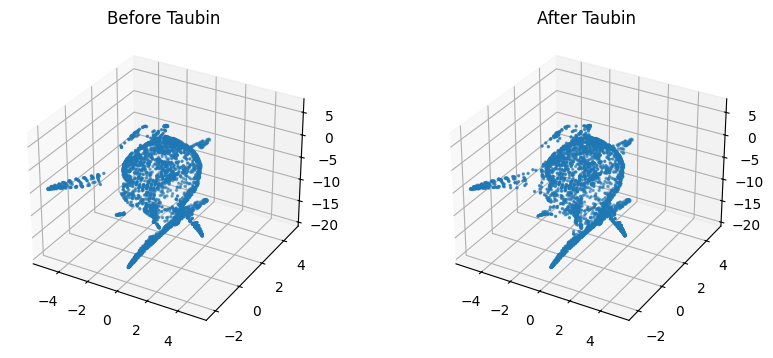

In [84]:
# Visualize boundary (downsample!)
idx = np.random.choice(boundary_vertices, size=3000, replace=False)

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121, projection="3d")
ax1.scatter(V[idx,0], V[idx,1], V[idx,2], s=2)
ax1.set_title("Before Taubin")

ax2 = fig.add_subplot(122, projection="3d")
ax2.scatter(V_smooth[idx,0], V_smooth[idx,1], V_smooth[idx,2], s=2)
ax2.set_title("After Taubin")

plt.show()

[INFO] Loaded 357409 shark vertices
[INFO] Saved oriented shark point cloud


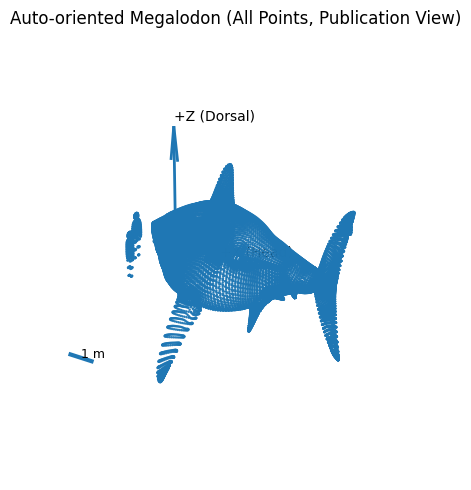

[INFO] Building Delaunay tetrahedralization (DEMO) ...
[INFO] Saved DEMO closed tetrahedral mesh
Outputs:
 - shark_oriented.npy
 - shark_oriented_closed_tetmesh_demo.npz


In [85]:
# ============================================================
# Auto-oriented Megalodon
# Use ALL shark points (no subsampling)
# Publication figure + DEMO closed tet mesh
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import Delaunay

# ------------------------------------------------------------
# 1. Load OBJ (vertices only)
# ------------------------------------------------------------
pts = []
with open("base_megalodon.obj") as f:
    for line in f:
        if line.startswith("v "):
            _, x, y, z = line.split()
            pts.append([float(x), float(y), float(z)])

P = np.asarray(pts)   # (N,3)
print(f"[INFO] Loaded {len(P)} shark vertices")

# ------------------------------------------------------------
# 2. Center + PCA auto-orientation
# ------------------------------------------------------------
P = P - P.mean(axis=0)

pca = PCA(n_components=3)
P = pca.fit_transform(P)

# ------------------------------------------------------------
# 3. Resolve sign ambiguity (biological heuristics)
# ------------------------------------------------------------

# Head should be +X
if np.mean(P[P[:,0] > 0, 0]) < abs(np.mean(P[P[:,0] < 0, 0])):
    P[:,0] *= -1

# Dorsal should be +Z
if np.mean(P[P[:,2] > 0, 2]) < abs(np.mean(P[P[:,2] < 0, 2])):
    P[:,2] *= -1

# ------------------------------------------------------------
# 4. Scale to physical size (~10 m length)
# ------------------------------------------------------------
length = P[:,0].max() - P[:,0].min()
P *= 10.0 / length

np.save("shark_oriented.npy", P)
print("[INFO] Saved oriented shark point cloud")

# ------------------------------------------------------------
# 5. Publication-quality visualization (NO SAMPLING)
# ------------------------------------------------------------
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(P[:,0], P[:,1], P[:,2], s=0.6, alpha=0.9)

# Direction axes
ax.quiver(0,0,0, 2,0,0, linewidth=2)
ax.text(2.1,0,0,"+X (Head)", fontsize=10)

ax.quiver(0,0,0, 0,0,2, linewidth=2)
ax.text(0,0,2.1,"+Z (Dorsal)", fontsize=10)

# Scale bar (1 m)
xmin, ymin, zmin = P.min(axis=0)
ax.plot([xmin, xmin+1], [ymin, ymin], [zmin, zmin], linewidth=3)
ax.text(xmin+0.5, ymin, zmin, "1 m", fontsize=9)

ax.set_title("Auto-oriented Megalodon (All Points, Publication View)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6. DEMO closed tetrahedral mesh (ALL points)
# ------------------------------------------------------------
print("[INFO] Building Delaunay tetrahedralization (DEMO) ...")
deln = Delaunay(P)
tets = deln.simplices

np.savez(
    "shark_oriented_closed_tetmesh_demo.npz",
    points=P,
    tets=tets
)

print("[INFO] Saved DEMO closed tetrahedral mesh")
print("Outputs:")
print(" - shark_oriented.npy")
print(" - shark_oriented_closed_tetmesh_demo.npz")

[INFO] Loaded 357409 shark vertices
[INFO] Estimating curvature proxy...
[INFO] Sampled 160834 points (~45.0%)


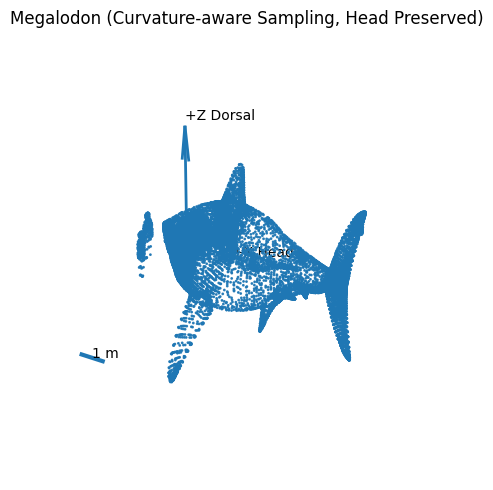

[INFO] Building DEMO Delaunay mesh (sampled points)...
[INFO] Saved:
 - shark_oriented.npy (full)
 - shark_oriented_closed_tetmesh_demo.npz (sampled DEMO)


In [86]:
# ============================================================
# Auto-oriented Megalodon
# Curvature-aware adaptive sampling (~45%)
# Head + teeth preserved at higher density
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import Delaunay

# ------------------------------------------------------------
# 1. Load OBJ (vertices only)
# ------------------------------------------------------------
pts = []
with open("base_megalodon.obj") as f:
    for line in f:
        if line.startswith("v "):
            _, x, y, z = line.split()
            pts.append([float(x), float(y), float(z)])

P = np.asarray(pts)
print(f"[INFO] Loaded {len(P)} shark vertices")

# ------------------------------------------------------------
# 2. Center + PCA auto-orientation
# ------------------------------------------------------------
P -= P.mean(axis=0)
P = PCA(n_components=3).fit_transform(P)

# ------------------------------------------------------------
# 3. Resolve sign ambiguity
# ------------------------------------------------------------
# Head → +X
if np.mean(P[P[:,0] > 0, 0]) < abs(np.mean(P[P[:,0] < 0, 0])):
    P[:,0] *= -1

# Dorsal → +Z
if np.mean(P[P[:,2] > 0, 2]) < abs(np.mean(P[P[:,2] < 0, 2])):
    P[:,2] *= -1

# ------------------------------------------------------------
# 4. Scale to ~10 m
# ------------------------------------------------------------
length = np.ptp(P[:, 0])
P *= 10.0 / length
np.save("shark_oriented.npy", P)

# ------------------------------------------------------------
# 5. Curvature proxy via local PCA (kNN)
# ------------------------------------------------------------
print("[INFO] Estimating curvature proxy...")
k = 20
nbrs = NearestNeighbors(n_neighbors=k).fit(P)
_, idx = nbrs.kneighbors(P)

curv = np.zeros(len(P))
for i in range(len(P)):
    local = P[idx[i]]
    cov = np.cov(local.T)
    eigvals = np.linalg.eigvalsh(cov)
    curv[i] = eigvals[0] / eigvals.sum()  # smallest / total

curv = (curv - curv.min()) / (curv.max() - curv.min() + 1e-12)

# ------------------------------------------------------------
# 6. Head + teeth bias (front 25% in X)
# ------------------------------------------------------------
x_range = np.ptp(P[:, 0])
x_norm = (P[:, 0] - P[:, 0].min()) / x_range
head_mask = x_norm > 0.75   # front 25%

# ------------------------------------------------------------
# 7. Importance sampling (~45%)
# ------------------------------------------------------------
target_ratio = 0.45
N_target = int(target_ratio * len(P))

# Base probability from curvature
prob = 0.3 + 0.7 * curv

# Boost head / teeth
prob[head_mask] *= 2.0

# Normalize
prob /= prob.sum()

idx_sampled = np.random.choice(len(P), N_target, replace=False, p=prob)
P_s = P[idx_sampled]

print(f"[INFO] Sampled {len(P_s)} points (~{100*target_ratio:.1f}%)")

# ------------------------------------------------------------
# 8. Publication visualization (sampled)
# ------------------------------------------------------------
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(P_s[:,0], P_s[:,1], P_s[:,2], s=1.0, alpha=0.9)

ax.quiver(0,0,0, 2,0,0, linewidth=2)
ax.text(2.1,0,0,"+X Head")

ax.quiver(0,0,0, 0,0,2, linewidth=2)
ax.text(0,0,2.1,"+Z Dorsal")

xmin, ymin, zmin = P_s.min(axis=0)
ax.plot([xmin, xmin+1],[ymin,ymin],[zmin,zmin],linewidth=3)
ax.text(xmin+0.5,ymin,zmin,"1 m")

ax.set_title("Megalodon (Curvature-aware Sampling, Head Preserved)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9. DEMO tetrahedralization (SAFE SIZE)
# ------------------------------------------------------------
print("[INFO] Building DEMO Delaunay mesh (sampled points)...")
deln = Delaunay(P_s)
tets = deln.simplices

np.savez(
    "shark_oriented_closed_tetmesh_demo.npz",
    points=P_s,
    tets=tets
)

print("[INFO] Saved:")
print(" - shark_oriented.npy (full)")
print(" - shark_oriented_closed_tetmesh_demo.npz (sampled DEMO)")

Loading points from base_megalodon.obj...
Loaded 357409 points
Saved oriented point cloud to shark_oriented.npy
Computing Delaunay tetrahedralization on all points...
This may take considerable time and memory for very dense clouds...
Generated 2,343,373 tetrahedra
Saved full tetrahedral mesh to shark_oriented_closed_tetmesh.npz


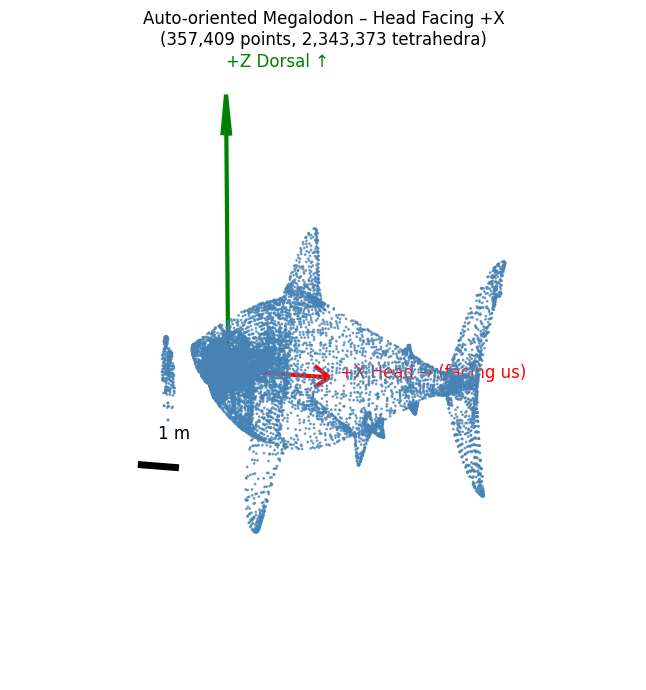

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import Delaunay
import os

n_points = 100000  # Number of points to plot

# -----------------------------
# Load OBJ point cloud
# -----------------------------
def load_obj_points(filename):
    pts = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('v '):
                parts = line.split()
                if len(parts) >= 4:
                    try:
                        x, y, z = map(float, parts[1:4])
                        pts.append([x, y, z])
                    except ValueError:
                        continue  # skip malformed lines
    if not pts:
        raise ValueError(f"No valid vertex lines found in {filename}")
    return np.asarray(pts)

# -----------------------------
# Main processing
# -----------------------------
def process_shark_obj(input_file="base_megalodon.obj", output_prefix="shark_oriented"):
    print(f"Loading points from {input_file}...")
    P = load_obj_points(input_file)
    print(f"Loaded {P.shape[0]} points")

    # Center the point cloud
    P -= P.mean(axis=0)

    # Auto-orientation using PCA
    pca = PCA(n_components=3)
    P_pca = pca.fit_transform(P)

    # --- Head direction: make head face +X (towards positive X) ---
    # The head is typically the wider, bulkier end (higher variance in Y/Z)
    # Compute spread (std in perpendicular directions) on both halves
    pos_half = P_pca[P_pca[:, 0] > 0]
    neg_half = P_pca[P_pca[:, 0] < 0]
    spread_pos = np.std(pos_half[:, 1]) + np.std(pos_half[:, 2])
    spread_neg = np.std(neg_half[:, 1]) + np.std(neg_half[:, 2])

    if spread_pos > spread_neg:
        # Current +X side is wider → already head towards +X
        pass
    else:
        # Flip to make wider side +X (head towards us in standard view)
        P_pca[:, 0] *= -1

    # --- Dorsal direction: make dorsal side +Z ---
    # Dorsal is the side with the fin (usually thinner/less spread in some models, but often asymmetric)
    # Use mean Z on upper vs lower half
    upper = P_pca[P_pca[:, 2] > 0, 2]
    lower = P_pca[P_pca[:, 2] < 0, 2]
    if np.mean(upper) < abs(np.mean(lower)):
        P_pca[:, 2] *= -1

    # Scale to ~10 m length along X (head to tail)
    x_range = P_pca[:, 0].max() - P_pca[:, 0].min()
    scale_factor = 10.0 / x_range
    P_scaled = P_pca * scale_factor

    # Save oriented full point cloud
    np.save(f"{output_prefix}.npy", P_scaled)
    print(f"Saved oriented point cloud to {output_prefix}.npy")

    # -----------------------------
    # Full tetrahedralization (using ALL points)
    # -----------------------------
    print("Computing Delaunay tetrahedralization on all points...")
    print("This may take considerable time and memory for very dense clouds...")
    
    deln = Delaunay(P_scaled)
    tets = deln.simplices
    
    n_tets = tets.shape[0]
    print(f"Generated {n_tets:,} tetrahedra")

    # Save full tet mesh
    np.savez(f"{output_prefix}_closed_tetmesh.npz",
             points=P_scaled,
             tets=tets)
    print(f"Saved full tetrahedral mesh to {output_prefix}_closed_tetmesh.npz")

    # -----------------------------
    # Visualization (subsampled for clarity)
    # -----------------------------
    n_plot = min(n_points, len(P_scaled))
    idx = np.random.choice(len(P_scaled), n_plot, replace=False)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(P_scaled[idx, 0], P_scaled[idx, 1], P_scaled[idx, 2],
               s=1, c='steelblue', alpha=0.7, depthshade=True)
    
    # Orientation arrows (head towards +X, dorsal +Z)
    ax.quiver(0, 0, 0, 3, 0, 0, color='red', linewidth=3, arrow_length_ratio=0.15)
    ax.text(3.3, 0, 0, "+X Head → (facing us)", color='red', fontsize=12)
    
    ax.quiver(0, 0, 0, 0, 0, 3, color='green', linewidth=3, arrow_length_ratio=0.15)
    ax.text(0, 0, 3.3, "+Z Dorsal ↑", color='green', fontsize=12)
    
    # Scale bar (1 meter)
    x0, y0, z0 = P_scaled.min(axis=0) + 0.5  # slight offset for visibility
    ax.plot([x0, x0 + 1], [y0, y0], [z0, z0], color='black', linewidth=5)
    ax.text(x0 + 0.5, y0, z0 + 0.3, "1 m", color='black', fontsize=12)
    
    ax.set_title(f"Auto-oriented Megalodon – Head Facing +X\n"
                 f"({len(P_scaled):,} points, {n_tets:,} tetrahedra)")
    ax.set_axis_off()
    
    # Optimal publication view: slightly from front-above to see head facing us
    ax.view_init(elev=15, azim=-75)  # adjust azim for best head visibility
    
    plt.tight_layout()
    plt.show()

    return P_scaled, tets

# -----------------------------
# Run the processing
# -----------------------------
if __name__ == "__main__":
    input_obj = "base_megalodon.obj"
    
    if not os.path.exists(input_obj):
        print(f"Error: File '{input_obj}' not found in current directory!")
        print("Please ensure 'base_megalodon.obj' is present.")
    else:
        points, tetrahedra = process_shark_obj(input_obj)

In [88]:
import numpy as np

data = np.load("shark_oriented_closed_tetmesh_demo.npz")
rest_pos = data["points"]      # (V,3)
tet_idx  = data["tets"]        # (T,4)
print("Points shape:", rest_pos.shape)
print("Tetrahedra shape:", tet_idx.shape)

Points shape: (160834, 3)
Tetrahedra shape: (1046077, 4)


In [16]:
# import numpy as np
# import pytetwild

# # Input: your cleaned / simplified Megalodon surface
# V_in = rest_pos.astype(np.float64)
# F_in = tet_idx.astype(np.int32)

# print("Running TetWild refinement and tetrahedralization…")

# V_tet, T_tet = pytetwild.tetrahedralize(V_in, F_in)

# print("TetWild tetrahedral mesh generated ✓")
# print("  Vertices:", V_tet.shape)
# print("  Tets    :", T_tet.shape)

In [17]:
import trimesh
import numpy as np

# ------------------------------------------------------------
# Load base surface mesh (NO filtering, NO tetrahedral mesh)
# ------------------------------------------------------------
print("[INFO] Loading base_megalodon.obj ...")

mesh = trimesh.load("base_megalodon.obj", process=False)

# If OBJ loads as a Scene, merge geometries
if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(
        [g for g in mesh.geometry.values()
         if isinstance(g, trimesh.Trimesh)]
    )

assert isinstance(mesh, trimesh.Trimesh)
print(f"[INFO] Surface mesh loaded")
print(f"  Vertices: {len(mesh.vertices):,}")
print(f"  Faces   : {len(mesh.faces):,}")

# ------------------------------------------------------------
# Minimal preprocessing for TetWild (FAST + SAFE)
# ------------------------------------------------------------

# 1. Ensure float64 (TetWild requirement)
mesh.vertices = mesh.vertices.astype(np.float64)

# 2. Remove degenerate / zero-area faces (critical for TetWild)
mesh.remove_degenerate_faces()
mesh.remove_duplicate_faces()
mesh.remove_unreferenced_vertices()

# 3. Fix face winding consistency (does NOT enforce watertight)
mesh.fix_normals()

print("[INFO] Preprocessing complete")
print(f"  Clean vertices: {len(mesh.vertices):,}")
print(f"  Clean faces   : {len(mesh.faces):,}")

# ------------------------------------------------------------
# Export clean shark surface
# ------------------------------------------------------------
mesh.export("shark_surface.obj")
print("[INFO] Saved shark_surface.obj (clean surface, TetWild-ready)")

[INFO] Loading base_megalodon.obj ...
[INFO] Surface mesh loaded
  Vertices: 420,178
  Faces   : 714,120


/var/folders/q1/xn03yx0d3lb4vlk97t91k1380000gn/T/ipykernel_89611/3653452156.py:31: DeprecationWarning: `remove_degenerate_faces` is deprecated and will be removed in March 2024 replace with `self.update_faces(self.nondegenerate_faces(height=height))`
  mesh.remove_degenerate_faces()
/var/folders/q1/xn03yx0d3lb4vlk97t91k1380000gn/T/ipykernel_89611/3653452156.py:32: DeprecationWarning: `remove_duplicate_faces` is deprecated and will be removed in March 2024: replace with `mesh.update_faces(mesh.unique_faces())`
  mesh.remove_duplicate_faces()


[INFO] Preprocessing complete
  Clean vertices: 420,178
  Clean faces   : 714,120
[INFO] Saved shark_surface.obj (clean surface, TetWild-ready)


In [20]:
import numpy as np
import trimesh
from scipy.spatial import cKDTree

# -------------------------------------------------
# 1. Load surface mesh (OBJ)
# -------------------------------------------------
mesh = trimesh.load("shark_surface.obj", process=False)

if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(
        [g for g in mesh.geometry.values()
         if isinstance(g, trimesh.Trimesh)]
    )

if not isinstance(mesh, trimesh.Trimesh):
    raise ValueError("Input mesh is not a triangular surface")

print("[INFO] Loaded surface mesh")
print("  Vertices:", mesh.vertices.shape)
print("  Faces   :", mesh.faces.shape)

# -------------------------------------------------
# 2. Minimal but SAFE cleaning for TetWild
# -------------------------------------------------
mesh.vertices = mesh.vertices.astype(np.float64)

mesh.remove_duplicate_faces()
mesh.remove_degenerate_faces()
mesh.remove_unreferenced_vertices()
mesh.remove_infinite_values()

# Fix normals & recenter (safe, cheap)
mesh.fix_normals()
mesh.rezero()

# NOTE:
# ❌ no remove_non_manifold_edges (does not exist)
# ❌ no aggressive hole filling unless necessary
# TetWild can handle small holes

print("[INFO] Basic cleaning complete")

# -------------------------------------------------
# 3. Curvature proxy via normal variation (kNN)
# -------------------------------------------------
V = mesh.vertices
N = mesh.vertex_normals

tree = cKDTree(V)
k = 20
_, idx = tree.query(V, k=k)

curv = np.zeros(len(V))
for i in range(len(V)):
    curv[i] = np.mean(
        np.linalg.norm(N[idx[i]] - N[i], axis=1)
    )

# Normalize curvature
curv = (curv - curv.min()) / (curv.max() - curv.min() + 1e-12)

# -------------------------------------------------
# 4. Head / teeth boost (front 25% in X)
# -------------------------------------------------
x_range = np.ptp(V[:, 0])
x_norm = (V[:, 0] - V[:, 0].min()) / (x_range + 1e-12)
head_mask = x_norm > 0.75
curv[head_mask] *= 2.0

print("[INFO] Curvature + head weighting computed")

# -------------------------------------------------
# 5. Curvature-aware decimation (QEM)
# -------------------------------------------------
target_keep = 0.55  # keep ~55% faces
n_faces_target = int(len(mesh.faces) * target_keep)

keep_ratio = 0.45

# weights = curv + 0.1
# weights /= weights.sum()

# n_keep = int(len(V) * keep_ratio)
# keep_idx = np.random.choice(
#     len(V), size=n_keep, replace=False, p=weights
# )

# V_s = V[keep_idx]
# face_mask = np.all(np.isin(mesh.faces, keep_idx), axis=1)
# F_s = mesh.faces[face_mask]

# # reindex
# old2new = -np.ones(len(V), dtype=int)
# old2new[keep_idx] = np.arange(len(keep_idx))
# F_s = old2new[F_s]
# mesh_s = trimesh.Trimesh(
#     vertices=V_s,
#     faces=F_s,
#     process=False
# )

mesh_s = mesh.copy()
# mesh_s = mesh.simplify_quadratic_decimation(n_faces_target)

mesh_s.remove_unreferenced_vertices()
mesh_s.remove_degenerate_faces()
mesh_s.fix_normals()
mesh_s.rezero()

print("[INFO] Simplified surface mesh")
print("  Vertices:", mesh_s.vertices.shape)
print("  Faces   :", mesh_s.faces.shape)

# -------------------------------------------------
# 6. Save preprocessed surface for TetWild
# -------------------------------------------------
mesh_s.export("shark_surface_preprocessed.obj")
print("[INFO] Saved shark_surface_preprocessed.obj (TetWild-ready)")

[INFO] Loaded surface mesh
  Vertices: (420178, 3)
  Faces   : (714120, 3)


/var/folders/q1/xn03yx0d3lb4vlk97t91k1380000gn/T/ipykernel_89611/210290534.py:28: DeprecationWarning: `remove_duplicate_faces` is deprecated and will be removed in March 2024: replace with `mesh.update_faces(mesh.unique_faces())`
  mesh.remove_duplicate_faces()
/var/folders/q1/xn03yx0d3lb4vlk97t91k1380000gn/T/ipykernel_89611/210290534.py:29: DeprecationWarning: `remove_degenerate_faces` is deprecated and will be removed in March 2024 replace with `self.update_faces(self.nondegenerate_faces(height=height))`
  mesh.remove_degenerate_faces()


[INFO] Basic cleaning complete
[INFO] Curvature + head weighting computed


/var/folders/q1/xn03yx0d3lb4vlk97t91k1380000gn/T/ipykernel_89611/210290534.py:107: DeprecationWarning: `remove_degenerate_faces` is deprecated and will be removed in March 2024 replace with `self.update_faces(self.nondegenerate_faces(height=height))`
  mesh_s.remove_degenerate_faces()


[INFO] Simplified surface mesh
  Vertices: (420178, 3)
  Faces   : (714120, 3)
[INFO] Saved shark_surface_preprocessed.obj (TetWild-ready)


In [2]:

import pytetwild
import trimesh
import numpy as np

mesh = trimesh.load("shark_surface_preprocessed.obj", process=False)

V_in = mesh.vertices.astype(np.float64)
F_in = mesh.faces.astype(np.int32)

print("[INFO] Running TetWild tetrahedralization (Python API)...")

V_tet, T_tet = pytetwild.tetrahedralize(V_in, F_in)

print("[INFO] TetWild finished")
print("  Tet vertices:", V_tet.shape)
print("  Tetrahedra :", T_tet.shape)

[INFO] Running TetWild tetrahedralization (Python API)...
Starting tetrahedralization process...
Starting tetrahedralization...
Tetrahedralization complete.Loading mesh...
Loaded mesh data into GEO::Mesh.
Initialized AABBWrapper.
Created Mesh instance for output.
bbox_diag_length = 28.0967
ideal_edge_length = 1.40483
stage = 2
eps_input = 0.0280967
eps = 0.015554
eps_simplification = 0.0124432
eps_coplanar = 2.80967e-05
dd = 0.0187311
dd_simplification = 0.0149849
[2025-12-28 23:46:30.826] [float-tetwild] [info] remove duplicates: 
[2025-12-28 23:46:30.826] [float-tetwild] [info] #v: 420178 -> 357406
[2025-12-28 23:46:30.826] [float-tetwild] [info] #f: 714120 -> 714120
collapsing 4.32263
swapping 0.0238124
[2025-12-28 23:46:35.308] [float-tetwild] [info] remove duplicates: 
[2025-12-28 23:46:35.308] [float-tetwild] [info] #v: 14121 -> 14121
[2025-12-28 23:46:35.308] [float-tetwild] [info] #f: 22190 -> 22190
[2025-12-28 23:46:35.308] [float-tetwild] [info] #v = 14121
[2025-12-28 23:46:3

In [3]:
import numpy as np
import pyvista as pv

# ============================================================
# 1. Convert surface mesh → PyVista PolyData
# ============================================================
# VTK face format: [3, i0, i1, i2]
faces_vtk = np.hstack(
    [np.full((F_in.shape[0], 1), 3, dtype=np.int32), F_in]
).ravel()

surface_mesh = pv.PolyData(
    V_in.astype(np.float64),
    faces_vtk
)

# ============================================================
# 2. Convert tetrahedral mesh → PyVista UnstructuredGrid
# ============================================================
# VTK tetra cell format: [4, i0, i1, i2, i3]
num_tets = T_tet.shape[0]

cells = np.hstack(
    [np.full((num_tets, 1), 4, dtype=np.int32), T_tet]
).ravel()

celltypes = np.full(num_tets, pv.CellType.TETRA, dtype=np.uint8)

tetrahedral_mesh = pv.UnstructuredGrid(
    cells,
    celltypes,
    V_tet.astype(np.float64)
)

# ============================================================
# 3. PyVista visualization
# ============================================================
p = pv.Plotter(
    shape=(1, 2),
    border=False,
    window_size=(1200, 520)
)

# -------------------------
# Left — input surface mesh
# -------------------------
p.subplot(0, 0)
p.add_text("Input Surface Mesh", font_size=12)

p.add_mesh(
    surface_mesh,
    color="white",
    opacity=0.22,
    show_edges=True,
    edge_color=(0.2, 0.2, 0.2),
    line_width=0.25,
    lighting=True,
    smooth_shading=True,
    ambient=0.15,
    diffuse=0.75,
    specular=0.1
)

p.add_axes(interactive=False)
p.camera_position = "iso"

# -------------------------
# Right — TetWild tetrahedral mesh
# -------------------------
p.subplot(0, 1)
p.add_text("TetWild Tetrahedral Mesh", font_size=12)

p.add_mesh(
    tetrahedral_mesh,
    color=(0.55, 0.75, 0.95),
    opacity=0.16,
    show_edges=True,
    edge_color=(0.1, 0.2, 0.4),
    line_width=0.22,
    lighting=True,
    smooth_shading=True,
    ambient=0.18,
    diffuse=0.72,
    specular=0.08
)

p.add_axes(interactive=False)

# -------------------------
# Sync cameras
# -------------------------
p.link_views()
p.disable_parallel_projection()
p.show()

Widget(value='<iframe src="http://localhost:54949/index.html?ui=P_0x158df0590_0&reconnect=auto" class="pyvista…

In [4]:
import numpy as np

def ddg_curvatures(V, F):
    """
    Mixed Voronoi DDG curvature:
    returns Gaussian curvature K and mean curvature magnitude H
    """
    nV = len(V)
    A = np.zeros(nV)              # mixed Voronoi area
    angle_sum = np.zeros(nV)      # angle defect
    Hn = np.zeros((nV, 3))        # mean curvature normal accumulator

    for tri in F:
        i, j, k = tri
        vi, vj, vk = V[i], V[j], V[k]

        # Edge vectors
        e_ij = vj - vi
        e_ik = vk - vi
        e_jk = vk - vj

        # Edge lengths squared
        L_ij2 = np.dot(e_ij, e_ij)
        L_ik2 = np.dot(e_ik, e_ik)
        L_jk2 = np.dot(e_jk, e_jk)

        # Triangle area
        Af = 0.5 * np.linalg.norm(np.cross(e_ij, e_ik))
        if Af < 1e-14:
            continue

        # Angles via law of cosines
        alpha = np.arccos(np.clip(
            (L_ij2 + L_ik2 - L_jk2) / (2*np.sqrt(L_ij2*L_ik2)), -1, 1))
        beta = np.arccos(np.clip(
            (L_ij2 + L_jk2 - L_ik2) / (2*np.sqrt(L_ij2*L_jk2)), -1, 1))
        gamma = np.pi - alpha - beta

        obtuse = (alpha > np.pi/2) or (beta > np.pi/2) or (gamma > np.pi/2)

        if obtuse:
            A[i] += Af / 3
            A[j] += Af / 3
            A[k] += Af / 3
        else:
            cot_alpha = (L_ij2 + L_ik2 - L_jk2) / (4*Af)
            cot_beta  = (L_ij2 + L_jk2 - L_ik2) / (4*Af)
            cot_gamma = (L_ik2 + L_jk2 - L_ij2) / (4*Af)

            A[i] += (L_ik2 * cot_beta + L_ij2 * cot_gamma) / 8
            A[j] += (L_ij2 * cot_gamma + L_jk2 * cot_alpha) / 8
            A[k] += (L_jk2 * cot_alpha + L_ik2 * cot_beta) / 8

            # Mean curvature normal (cotan Laplacian)
            Hn[i] += (cot_beta * (vj - vi) + cot_gamma * (vk - vi)) / 2
            Hn[j] += (cot_gamma * (vi - vj) + cot_alpha * (vk - vj)) / 2
            Hn[k] += (cot_alpha * (vi - vk) + cot_beta * (vj - vk)) / 2

        angle_sum[i] += alpha
        angle_sum[j] += beta
        angle_sum[k] += gamma

    # Gaussian curvature
    K = (2*np.pi - angle_sum) / (A + 1e-14)

    # Mean curvature magnitude
    H = 0.5 * np.linalg.norm(Hn, axis=1) / (A + 1e-14)

    return K, H

In [5]:
V_full = V_in.astype(np.float64)
F_full = F_in.astype(np.int32)

# Build tet mesh first (same as your base)
num_tets = T_tet.shape[0]

cells = np.hstack(
    [np.full((num_tets, 1), 4, dtype=np.int32), T_tet]
).ravel()

celltypes = np.full(num_tets, pv.CellType.TETRA, dtype=np.uint8)

tetrahedral_mesh = pv.UnstructuredGrid(
    cells,
    celltypes,
    V_tet.astype(np.float64)
)

# Extract boundary surface (this IS the compressed Voronoi surface)
surf_comp = tetrahedral_mesh.extract_surface().triangulate()

V_comp = surf_comp.points
F_comp = surf_comp.faces.reshape(-1, 4)[:, 1:]

In [6]:
def ddg_curvatures(V, F):
    nV = len(V)
    A = np.zeros(nV)
    angle_sum = np.zeros(nV)
    Hn = np.zeros((nV, 3))

    for (i, j, k) in F:
        vi, vj, vk = V[i], V[j], V[k]

        e_ij = vj - vi
        e_ik = vk - vi
        e_jk = vk - vj

        L_ij2 = np.dot(e_ij, e_ij)
        L_ik2 = np.dot(e_ik, e_ik)
        L_jk2 = np.dot(e_jk, e_jk)

        Af = 0.5 * np.linalg.norm(np.cross(e_ij, e_ik))
        if Af < 1e-14:
            continue

        alpha = np.arccos(np.clip(
            (L_ij2 + L_ik2 - L_jk2) / (2*np.sqrt(L_ij2*L_ik2)), -1, 1))
        beta = np.arccos(np.clip(
            (L_ij2 + L_jk2 - L_ik2) / (2*np.sqrt(L_ij2*L_jk2)), -1, 1))
        gamma = np.pi - alpha - beta

        obtuse = (alpha > np.pi/2) or (beta > np.pi/2) or (gamma > np.pi/2)

        if obtuse:
            A[i] += Af / 3
            A[j] += Af / 3
            A[k] += Af / 3
        else:
            cot_alpha = (L_ij2 + L_ik2 - L_jk2) / (4*Af)
            cot_beta  = (L_ij2 + L_jk2 - L_ik2) / (4*Af)
            cot_gamma = (L_ik2 + L_jk2 - L_ij2) / (4*Af)

            A[i] += (L_ik2 * cot_beta + L_ij2 * cot_gamma) / 8
            A[j] += (L_ij2 * cot_gamma + L_jk2 * cot_alpha) / 8
            A[k] += (L_jk2 * cot_alpha + L_ik2 * cot_beta) / 8

            Hn[i] += (cot_beta * (vj - vi) + cot_gamma * (vk - vi)) / 2
            Hn[j] += (cot_gamma * (vi - vj) + cot_alpha * (vk - vj)) / 2
            Hn[k] += (cot_alpha * (vi - vk) + cot_beta * (vj - vk)) / 2

        angle_sum[i] += alpha
        angle_sum[j] += beta
        angle_sum[k] += gamma

    K = (2*np.pi - angle_sum) / (A + 1e-14)
    H = 0.5 * np.linalg.norm(Hn, axis=1) / (A + 1e-14)

    return K, H

In [7]:
K_full, H_full = ddg_curvatures(V_full, F_full)
K_comp, H_comp = ddg_curvatures(V_comp, F_comp)

eps = 1e-12
logH_full = np.log10(np.abs(H_full) + eps)
logH_comp = np.log10(np.abs(H_comp) + eps)

clim = (min(logH_full.min(), logH_comp.min()),
        max(logH_full.max(), logH_comp.max()))

In [9]:
def make_surface(V, F):
    faces_vtk = np.hstack(
        [np.full((F.shape[0], 1), 3, dtype=np.int32), F]
    ).ravel()
    return pv.PolyData(V, faces_vtk)

surf_full = make_surface(V_full, F_full)
surf_comp = make_surface(V_comp, F_comp)

surf_full.point_data["logH"] = logH_full
surf_comp.point_data["logH"] = logH_comp

In [10]:
p = pv.Plotter(
    shape=(1, 2),
    border=False,
    window_size=(1200, 520)
)

# -------------------------
# Left — original surface
# -------------------------
p.subplot(0, 0)
p.add_text("Original Surface\nlog₁₀(|H|)", font_size=12)

p.add_mesh(
    surf_full,
    scalars="logH",
    cmap="inferno",
    clim=clim,
    smooth_shading=True,
    show_scalar_bar=False,
    scalar_bar_args=None
)

p.add_axes(interactive=False)
p.camera_position = "iso"

# -------------------------
# Right — compressed surface
# -------------------------
p.subplot(0, 1)
p.add_text("Compressed (TetWild Boundary)\nlog₁₀(|H|)", font_size=12)

p.add_mesh(
    surf_comp,
    scalars="logH",
    cmap="inferno",
    clim=clim,
    smooth_shading=True,
    show_scalar_bar=False,
    scalar_bar_args=None
)

p.add_axes(interactive=False)

# -------------------------
# Manually add LEFT-ONLY scalar bar (85% height)
# -------------------------
p.add_scalar_bar(
    title="log₁₀(|H|)",
    vertical=True,
    n_labels=6,
    width=0.035,        # thin bar
    height=0.85,        # ~85% of window height
    position_x=0.03,    # inside left subplot
    position_y=0.075,   # bottom padding
    title_font_size=11,
    label_font_size=10
)

# -------------------------
# Sync cameras
# -------------------------
p.link_views()
p.disable_parallel_projection()
p.show()

Widget(value='<iframe src="http://localhost:54949/index.html?ui=P_0x122138550_2&reconnect=auto" class="pyvista…

#### Curvature Difference definition
We define signed differences on the reference surface:
$$\Delta k_1 = k_1^{\text{compressed}} - k_1^{\text{full}}, \quad
\Delta k_2 = k_2^{\text{compressed}} - k_2^{\text{full}}$$

In [ ]:
# ============================================================
# 0. Imports
# ============================================================

import numpy as np
import trimesh
import pyvista as pv
from scipy.spatial import cKDTree


# ============================================================
# 1. Load meshes (robust to Scene objects)
# ============================================================

def to_mesh(m):
    if isinstance(m, trimesh.Scene):
        return trimesh.util.concatenate(
            [g for g in m.geometry.values()
             if isinstance(g, trimesh.Trimesh)]
        )
    return m

mesh_full = to_mesh(trimesh.load(
    "shark_surface.obj", process=False
))

mesh_comp = to_mesh(trimesh.load(
    "shark_surface_compressed.obj", process=False
))

assert mesh_full.is_watertight or True
assert mesh_comp.is_watertight or True


# Convert to PyVista for visualization
surf_full = pv.wrap(mesh_full)


# ============================================================
# 2. Curvature estimators
# ============================================================

def mean_curvature_signed(mesh):
    """
    Signed mean curvature magnitude using cotangent Laplacian
    """
    V = mesh.vertices
    F = mesh.faces
    nV = len(V)

    # Edge vectors per triangle
    tri = V[F]
    e0 = tri[:, 2] - tri[:, 1]
    e1 = tri[:, 0] - tri[:, 2]
    e2 = tri[:, 1] - tri[:, 0]

    # Triangle areas
    A = 0.5 * np.linalg.norm(np.cross(e1, e2), axis=1)

    # Cotangents
    cot0 = np.einsum("ij,ij->i", e1, e2) / (2*A + 1e-12)
    cot1 = np.einsum("ij,ij->i", e2, e0) / (2*A + 1e-12)
    cot2 = np.einsum("ij,ij->i", e0, e1) / (2*A + 1e-12)

    Hn = np.zeros((nV, 3))
    W  = np.zeros(nV)

    for (i, j, k), c0, c1, c2, area in zip(F, cot0, cot1, cot2, A):
        Hn[i] += c1 * (V[j] - V[i]) + c2 * (V[k] - V[i])
        Hn[j] += c2 * (V[k] - V[j]) + c0 * (V[i] - V[j])
        Hn[k] += c0 * (V[i] - V[k]) + c1 * (V[j] - V[k])

        W[i] += area / 3
        W[j] += area / 3
        W[k] += area / 3

    Hn /= (2 * W[:, None] + 1e-12)

    # Signed scalar mean curvature
    H = np.einsum("ij,ij->i", Hn, mesh.vertex_normals)
    return H


def gaussian_curvature(mesh):
    """
    Angle-defect Gaussian curvature (Trimesh-compatible)
    """
    V = mesh.vertices
    F = mesh.faces

    # Initial angle defect
    K = np.full(len(V), 2.0 * np.pi)

    tri = V[F]
    a = np.linalg.norm(tri[:, 1] - tri[:, 2], axis=1)
    b = np.linalg.norm(tri[:, 0] - tri[:, 2], axis=1)
    c = np.linalg.norm(tri[:, 0] - tri[:, 1], axis=1)

    # Triangle angles
    alpha = np.arccos(
        np.clip((b**2 + c**2 - a**2) / (2*b*c), -1.0, 1.0)
    )
    beta = np.arccos(
        np.clip((a**2 + c**2 - b**2) / (2*a*c), -1.0, 1.0)
    )
    gamma = np.pi - alpha - beta

    np.subtract.at(K, F[:, 0], alpha)
    np.subtract.at(K, F[:, 1], beta)
    np.subtract.at(K, F[:, 2], gamma)

    # ------------------------------------------------
    # Vertex area (barycentric)
    # ------------------------------------------------
    face_areas = mesh.area_faces
    A = np.zeros(len(V))
    np.add.at(A, F[:, 0], face_areas / 3.0)
    np.add.at(A, F[:, 1], face_areas / 3.0)
    np.add.at(A, F[:, 2], face_areas / 3.0)

    return K / (A + 1e-12)


# ============================================================
# 3. Principal curvatures — full (reference)
# ============================================================

H_full = mean_curvature_signed(mesh_full)
K_full = gaussian_curvature(mesh_full)

disc = np.maximum(H_full**2 - K_full, 0.0)
sqrt_disc = np.sqrt(disc)

k1_full = H_full + sqrt_disc
k2_full = H_full - sqrt_disc


# ============================================================
# 4. Principal curvatures — compressed
# ============================================================

H_comp = mean_curvature_signed(mesh_comp)
K_comp = gaussian_curvature(mesh_comp)

disc = np.maximum(H_comp**2 - K_comp, 0.0)
sqrt_disc = np.sqrt(disc)

k1_comp = H_comp + sqrt_disc
k2_comp = H_comp - sqrt_disc


# ============================================================
# 5. Map compressed curvatures → full surface
# ============================================================

def map_vertex_field(V_src, values_src, V_tgt, k=6):
    """
    k-NN inverse-distance weighted transfer
    """
    tree = cKDTree(V_src)
    dists, idx = tree.query(V_tgt, k=k)

    if k == 1:
        idx = idx[:, None]
        dists = dists[:, None]

    w = 1.0 / (dists + 1e-12)
    w /= w.sum(axis=1, keepdims=True)

    return np.sum(values_src[idx] * w, axis=1)


k1_comp_on_full = map_vertex_field(
    mesh_comp.vertices, k1_comp,
    mesh_full.vertices, k=6
)

k2_comp_on_full = map_vertex_field(
    mesh_comp.vertices, k2_comp,
    mesh_full.vertices, k=6
)


# ============================================================
# 6. Difference fields (defined ONLY on full surface)
# ============================================================
dk1 = k1_comp_on_full - k1_full
dk2 = k2_comp_on_full - k2_full

surf_full.point_data["dk1"] = dk1
surf_full.point_data["dk2"] = dk2

dmax = max(np.abs(dk1).max(), np.abs(dk2).max())
clim = (-dmax, dmax)

print(f"[INFO] Δk range: ±{dmax:.3e}")
eps = 1e-12
surf_full.point_data["dk1_log"] = np.sign(dk1) * np.log10(np.abs(dk1) + eps)
surf_full.point_data["dk2_log"] = np.sign(dk2) * np.log10(np.abs(dk2) + eps)

L = max(
    np.abs(surf_full.point_data["dk1_log"]).max(),
    np.abs(surf_full.point_data["dk2_log"]).max()
)

clim = (-L, L)


# ============================================================
# 7. Visualization — Δk₁ / Δk₂
# ============================================================

p = pv.Plotter(
    shape=(1, 2),
    border=False,
    window_size=(1200, 520)
)

# -------------------------
# Left — Δk₁
# -------------------------
p.subplot(0, 0)
p.add_text("Δk₁ (Compressed − Original)", font_size=12)

p.add_mesh(
    surf_full,
    scalars="dk1",
    cmap="coolwarm",
    clim=clim,
    smooth_shading=True,
    show_scalar_bar=False
)

p.camera_position = "iso"
p.remove_bounds_axes()

# -------------------------
# Right — Δk₂
# -------------------------
p.subplot(0, 1)
p.add_text("Δk₂ (Compressed − Original)", font_size=12)

p.add_mesh(
    surf_full,
    scalars="dk2",
    cmap="coolwarm",
    clim=clim,
    smooth_shading=True,
    show_scalar_bar=False
)

p.remove_bounds_axes()

# -------------------------
# Single LEFT scalar bar (global, symmetric)
# -------------------------
p.add_scalar_bar(
    title="Principal Curvature Difference",
    vertical=True,
    n_labels=7,
    width=0.035,
    height=0.85,
    position_x=0.03,
    position_y=0.075,
    fmt="%.2e",
    title_font_size=11,
    label_font_size=10
)

p.link_views()
p.disable_parallel_projection()
p.show()

[INFO] Δk range: ±6.656e+05


Widget(value='<iframe src="http://localhost:54949/index.html?ui=P_0x14e051bd0_4&reconnect=auto" class="pyvista…

In [13]:
import numpy as np
import trimesh
import pyvista as pv
from scipy.spatial import cKDTree

# ============================================================
# 1. Utilities
# ============================================================

def to_mesh(m):
    if isinstance(m, trimesh.Scene):
        return trimesh.util.concatenate(
            [g for g in m.geometry.values()
             if isinstance(g, trimesh.Trimesh)]
        )
    return m


def curvature_proxy(mesh, k=20):
    """
    Normal-variation curvature proxy (normalized to [0,1])
    """
    V = mesh.vertices
    N = mesh.vertex_normals

    tree = cKDTree(V)
    _, idx = tree.query(V, k=k)

    curv = np.mean(
        np.linalg.norm(N[idx] - N[:, None, :], axis=2),
        axis=1
    )

    return (curv - curv.min()) / (curv.max() - curv.min() + 1e-12)


def sample_surface_points(mesh, n_samples, curvature=None, boost=2.5):
    """
    Area-weighted surface sampling with optional curvature bias
    """
    faces = mesh.faces
    verts = mesh.vertices

    tri_pts = verts[faces]
    tri_areas = trimesh.triangles.area(tri_pts)

    if curvature is not None:
        face_curv = curvature[faces].mean(axis=1)
        weights = tri_areas * (1.0 + boost * face_curv)
    else:
        weights = tri_areas

    weights /= weights.sum()

    face_idx = np.random.choice(
        len(faces),
        size=n_samples,
        replace=True,
        p=weights
    )

    r1 = np.sqrt(np.random.rand(n_samples))
    r2 = np.random.rand(n_samples)

    v0 = tri_pts[face_idx, 0]
    v1 = tri_pts[face_idx, 1]
    v2 = tri_pts[face_idx, 2]

    samples = (
        (1 - r1)[:, None] * v0 +
        (r1 * (1 - r2))[:, None] * v1 +
        (r1 * r2)[:, None] * v2
    )

    return samples


def map_samples_to_vertices(V, P, d_samples, k=8):
    """
    Robust kNN inverse-distance mapping
    V         : (Nv, 3) vertices
    P         : (Ns, 3) sample points
    d_samples : (Ns,)  distances at samples
    """
    assert P.shape[0] == d_samples.shape[0], \
        "d_samples must match number of sample points"

    tree = cKDTree(V)
    dists, idx = tree.query(P, k=k)

    if k == 1:
        idx = idx[:, None]
        dists = dists[:, None]

    w = 1.0 / (dists + 1e-12)

    H = np.zeros(len(V))
    W = np.zeros(len(V))

    for j in range(k):
        np.add.at(H, idx[:, j], w[:, j] * d_samples)
        np.add.at(W, idx[:, j], w[:, j])

    return H / (W + 1e-12)


def trimesh_to_pv(V, F):
    faces_vtk = np.hstack(
        [np.full((F.shape[0], 1), 3, dtype=np.int32), F]
    ).ravel()
    return pv.PolyData(V.astype(np.float64), faces_vtk)


# ============================================================
# 2. Load meshes
# ============================================================

mesh_full = to_mesh(trimesh.load("shark_surface.obj", process=False))
mesh_comp = to_mesh(trimesh.load("shark_surface_compressed.obj", process=False))

print("[INFO] Meshes loaded")
print("  Full       :", mesh_full.vertices.shape, mesh_full.faces.shape)
print("  Compressed :", mesh_comp.vertices.shape, mesh_comp.faces.shape)

# ============================================================
# 3. Curvature-guided sampling
# ============================================================

curv_full = curvature_proxy(mesh_full)
curv_comp = curvature_proxy(mesh_comp)

N_SAMPLES = 200_000

P_full = sample_surface_points(
    mesh_full, N_SAMPLES, curvature=curv_full, boost=3.0
)

P_comp = sample_surface_points(
    mesh_comp, N_SAMPLES, curvature=curv_comp, boost=3.0
)

# ============================================================
# 4. Surface ↔ surface Hausdorff (sampled)
# ============================================================

tree_full = cKDTree(P_full)
tree_comp = cKDTree(P_comp)

# sample → sample distances
d_full, _ = tree_comp.query(P_full, k=1)
d_comp, _ = tree_full.query(P_comp, k=1)

print(f"[INFO] Hausdorff proxy max = {max(d_full.max(), d_comp.max()):.3e}")

# ============================================================
# 5. Map sampled Hausdorff → FULL mesh ONLY
# ============================================================

def map_samples_to_vertices(V, P, d_samples, k=8):
    """
    Smooth inverse-distance mapping of sample distances
    onto reference vertices.
    """
    tree = cKDTree(V)
    dists, idx = tree.query(P, k=k)

    if k == 1:
        idx = idx[:, None]
        dists = dists[:, None]

    w = 1.0 / (dists + 1e-12)

    H = np.zeros(len(V))
    W = np.zeros(len(V))

    for j in range(k):
        np.add.at(H, idx[:, j], w[:, j] * d_samples)
        np.add.at(W, idx[:, j], w[:, j])

    return H / (W + 1e-12)


# Map ONLY onto original surface
H_full = map_samples_to_vertices(
    mesh_full.vertices,
    P_full,
    d_full,
    k=8
)

print(
    "[INFO] Hausdorff field stats:",
    f"min={H_full.min():.3e},",
    f"max={H_full.max():.3e}"
)

# ============================================================
# 6. PyVista surface (REFERENCE ONLY)
# ============================================================

def trimesh_to_pv(V, F):
    faces_vtk = np.hstack(
        [np.full((F.shape[0], 1), 3, dtype=np.int32), F]
    ).ravel()
    return pv.PolyData(V.astype(np.float64), faces_vtk)

surf_full = trimesh_to_pv(
    mesh_full.vertices,
    mesh_full.faces
)

surf_full.point_data["hausdorff"] = H_full

# ============================================================
# 7. Visualization — FULL VIEWPORT (reference surface only)
# ============================================================

p = pv.Plotter(
    window_size=(900, 700),
    border=False
)

p.add_mesh(
    surf_full,
    scalars="hausdorff",
    cmap="inferno",
    clim=(0.0, H_full.max()),
    smooth_shading=True,
    show_scalar_bar=False   # critical
)

# Clean viewport
p.set_background("white")
p.remove_bounds_axes()

# Tight camera
p.camera_position = "iso"
p.camera.zoom(1.35)

# Overlay scalar bar (safe — now it exists)
p.add_scalar_bar(
    title="Hausdorff Distance",
    vertical=True,
    n_labels=6,
    width=0.04,
    height=0.9,
    position_x=0.02,
    position_y=0.05,
    fmt="%.2e",
    title_font_size=12,
    label_font_size=10
)

p.disable_parallel_projection()
p.show()

[INFO] Meshes loaded
  Full       : (420178, 3) (714120, 3)
  Compressed : (125823, 3) (99483, 3)
[INFO] Hausdorff proxy max = 1.988e+01
[INFO] Hausdorff field stats: min=0.000e+00, max=1.987e+01


Widget(value='<iframe src="http://localhost:54949/index.html?ui=P_0x12213b750_5&reconnect=auto" class="pyvista…

In [ ]:
import numpy as np
import trimesh
from scipy.spatial import cKDTree
import pyvista as pv

def curvature_proxy(mesh, k=20):
    """
    Curvature proxy via vertex normal variation
    """
    V = mesh.vertices
    N = mesh.vertex_normals

    tree = cKDTree(V)
    _, idx = tree.query(V, k=k)

    curv = np.zeros(len(V))
    for i in range(len(V)):
        curv[i] = np.mean(
            np.linalg.norm(N[idx[i]] - N[i], axis=1)
        )

    curv = (curv - curv.min()) / (curv.max() - curv.min() + 1e-12)
    return curv

def sample_surface_points(mesh, n_samples, curvature=None, boost=2.0):
    """
    Area-weighted surface sampling with optional curvature bias
    """
    faces = mesh.faces
    verts = mesh.vertices

    tri_pts = verts[faces]
    tri_areas = trimesh.triangles.area(tri_pts)

    if curvature is not None:
        face_curv = curvature[faces].mean(axis=1)
        weights = tri_areas * (1.0 + boost * face_curv)
    else:
        weights = tri_areas

    weights /= weights.sum()

    face_idx = np.random.choice(
        len(faces),
        size=n_samples,
        replace=True,
        p=weights
    )

    r1 = np.sqrt(np.random.rand(n_samples))
    r2 = np.random.rand(n_samples)

    v0 = tri_pts[face_idx, 0]
    v1 = tri_pts[face_idx, 1]
    v2 = tri_pts[face_idx, 2]

    samples = (
        (1 - r1)[:, None] * v0 +
        (r1 * (1 - r2))[:, None] * v1 +
        (r1 * r2)[:, None] * v2
    )

    return samples

def load_mesh(path):
    m = trimesh.load(path, process=False)
    if isinstance(m, trimesh.Scene):
        m = trimesh.util.concatenate(
            [g for g in m.geometry.values()
             if isinstance(g, trimesh.Trimesh)]
        )
    return m

mesh_full = load_mesh("shark_surface.obj")
mesh_comp = load_mesh("shark_surface_compressed.obj")

print("[INFO] Loaded meshes")
print("  Full:", mesh_full.vertices.shape, mesh_full.faces.shape)
print("  Comp:", mesh_comp.vertices.shape, mesh_comp.faces.shape)
curv_full = curvature_proxy(mesh_full)
curv_comp = curvature_proxy(mesh_comp)

N_SAMPLES = 200_000

P_full = sample_surface_points(
    mesh_full, N_SAMPLES, curvature=curv_full, boost=3.0
)
P_comp = sample_surface_points(
    mesh_comp, N_SAMPLES, curvature=curv_comp, boost=3.0
)
tree_full = cKDTree(P_full)
tree_comp = cKDTree(P_comp)

# Directed distances
d_full, _ = tree_comp.query(P_full, k=1)  # full → comp
d_comp, _ = tree_full.query(P_comp, k=1)  # comp → full

d_max = max(d_full.max(), d_comp.max())
print(f"[INFO] Hausdorff proxy max = {d_max:.6e}")
def map_samples_to_vertices(V, P, d, k=8):
    """
    Smooth kNN inverse-distance interpolation
    """
    tree = cKDTree(V)
    dists, idx = tree.query(P, k=k)

    if k == 1:
        idx = idx[:, None]
        dists = dists[:, None]

    w = 1.0 / (dists + 1e-12)

    H = np.zeros(len(V))
    W = np.zeros(len(V))

    for j in range(k):
        np.add.at(H, idx[:, j], w[:, j] * d)
        np.add.at(W, idx[:, j], w[:, j])

    return H / (W + 1e-12)


H_full = map_samples_to_vertices(
    mesh_full.vertices, P_full, d_full, k=8
)

H_comp = map_samples_to_vertices(
    mesh_comp.vertices, P_comp, d_comp, k=8
)
surf_full = pv.PolyData(mesh_full.vertices, 
    np.hstack([np.full((mesh_full.faces.shape[0],1),3), mesh_full.faces]).ravel()
)
surf_comp = pv.PolyData(mesh_comp.vertices, 
    np.hstack([np.full((mesh_comp.faces.shape[0],1),3), mesh_comp.faces]).ravel()
)

surf_full.point_data["hausdorff"] = H_full
surf_comp.point_data["hausdorff"] = H_comp

[INFO] Loaded meshes
  Full: (420178, 3) (714120, 3)
  Comp: (125823, 3) (99483, 3)
[INFO] Hausdorff proxy max = 1.987677e+01


In [41]:
surf_full.point_data["hausdorff"] = H_full
surf_comp.point_data["hausdorff"] = H_comp

# ============================================================
# 7. PyVista visualization (surface-sampled Hausdorff error)
# ============================================================
import pyvista as pv
import numpy as np

p = pv.Plotter(
    shape=(1, 2),
    border=False,
    window_size=(1200, 520)
)

# Shared color limits (robust)
h_max = max(H_full.max(), H_comp.max())
clim = (0.0, h_max)

# -------------------------
# Left — original surface
# -------------------------
p.subplot(0, 0)
p.add_text(
    "Original Surface\nSurface-Sampled Hausdorff Error",
    font_size=12
)

p.add_mesh(
    surf_full,
    scalars="hausdorff",
    cmap="inferno",
    clim=clim,
    smooth_shading=True,
    show_scalar_bar=False   # ❗ suppress per-mesh bars
)

p.add_axes(interactive=False)
p.camera_position = "iso"

# -------------------------
# Right — compressed surface
# -------------------------
p.subplot(0, 1)
p.add_text(
    "Compressed Surface (~45%)\nSurface-Sampled Hausdorff Error",
    font_size=12
)

p.add_mesh(
    surf_comp,
    scalars="hausdorff",
    cmap="inferno",
    clim=clim,
    smooth_shading=True,
    show_scalar_bar=False   # ❗ suppress per-mesh bars
)

p.add_axes(interactive=False)

# -------------------------
# Single LEFT scalar bar (tall, global)
# -------------------------
p.add_scalar_bar(
    title="Hausdorff Distance",
    vertical=True,
    n_labels=5,
    width=0.035,
    height=0.85,          # ~85% of viewport height
    position_x=0.025,     # anchored to far left
    position_y=0.075,
    title_font_size=11,
    label_font_size=10,
    fmt="%.2e"            # scientific notation (important here)
)

# -------------------------
# Sync cameras
# -------------------------
p.link_views()
p.disable_parallel_projection()

p.show()

Widget(value='<iframe src="http://localhost:54949/index.html?ui=P_0x3006fdf90_6&reconnect=auto" class="pyvista…

In [31]:
import numpy as np
import trimesh
from scipy.spatial import cKDTree

# -------------------------------------------------
# 1. Load surface mesh
# -------------------------------------------------
mesh = trimesh.load("shark_surface.obj", process=False)

if isinstance(mesh, trimesh.Scene):
    mesh = trimesh.util.concatenate(
        [g for g in mesh.geometry.values()
         if isinstance(g, trimesh.Trimesh)]
    )

if not isinstance(mesh, trimesh.Trimesh):
    raise ValueError("Input mesh is not triangular")

mesh.vertices = mesh.vertices.astype(np.float64)

print("[INFO] Loaded mesh")
print("  V:", mesh.vertices.shape)
print("  F:", mesh.faces.shape)

# -------------------------------------------------
# 2. Safe cleaning (do NOT destroy topology)
# -------------------------------------------------
mesh.remove_duplicate_faces()
mesh.remove_degenerate_faces()
mesh.remove_unreferenced_vertices()
mesh.remove_infinite_values()
mesh.fix_normals()
mesh.rezero()

# -------------------------------------------------
# 3. Curvature proxy (normal variation)
# -------------------------------------------------
V = mesh.vertices
N = mesh.vertex_normals

tree = cKDTree(V)
_, idx = tree.query(V, k=20)

curv = np.mean(
    np.linalg.norm(N[idx] - N[:, None, :], axis=2),
    axis=1
)

curv = (curv - curv.min()) / (curv.max() - curv.min() + 1e-12)

# -------------------------------------------------
# 4. Head / teeth boost
# -------------------------------------------------
x_norm = (V[:, 0] - V[:, 0].min()) / (np.ptp(V[:, 0]) + 1e-12)
curv[x_norm > 0.75] *= 2.0

print("[INFO] Curvature weighting ready")

# -------------------------------------------------
# 5. Surface point sampling (THIS IS THE FIX)
# -------------------------------------------------
n_surface_samples = int(0.45 * len(V))   # ~45% of vertex count

# Face areas for area-weighted sampling
face_areas = mesh.area_faces
face_probs = face_areas / face_areas.sum()

# Sample faces
face_ids = np.random.choice(
    len(mesh.faces),
    size=n_surface_samples,
    replace=True,
    p=face_probs
)

# Barycentric sampling on faces
u = np.random.rand(n_surface_samples)
v = np.random.rand(n_surface_samples)
mask = u + v > 1
u[mask] = 1 - u[mask]
v[mask] = 1 - v[mask]

w = 1 - u - v

tri = mesh.faces[face_ids]
P = (
    V[tri[:, 0]] * u[:, None] +
    V[tri[:, 1]] * v[:, None] +
    V[tri[:, 2]] * w[:, None]
)

# -------------------------------------------------
# 6. Curvature-weighted resampling (important)
# -------------------------------------------------
# Interpolate curvature to sampled points
curv_faces = curv[tri].mean(axis=1)
weights = curv_faces + 0.05
weights /= weights.sum()

keep = np.random.choice(
    len(P),
    size=n_surface_samples,
    replace=False,
    p=weights
)

P = P[keep]

print("[INFO] Sampled surface points:", P.shape)

# -------------------------------------------------
# 7. Save outputs for TetWild
# -------------------------------------------------
mesh.export("shark_surface_preprocessed.obj")

np.savetxt(
    "shark_surface_samples.xyz",
    P,
    fmt="%.8e"
)

print("[INFO] Saved:")
print("  shark_surface_preprocessed.obj")
print("  shark_surface_samples.xyz")

[INFO] Loaded mesh
  V: (420178, 3)
  F: (714120, 3)


/var/folders/q1/xn03yx0d3lb4vlk97t91k1380000gn/T/ipykernel_92418/2065430649.py:28: DeprecationWarning: `remove_duplicate_faces` is deprecated and will be removed in March 2024: replace with `mesh.update_faces(mesh.unique_faces())`
  mesh.remove_duplicate_faces()
/var/folders/q1/xn03yx0d3lb4vlk97t91k1380000gn/T/ipykernel_92418/2065430649.py:29: DeprecationWarning: `remove_degenerate_faces` is deprecated and will be removed in March 2024 replace with `self.update_faces(self.nondegenerate_faces(height=height))`
  mesh.remove_degenerate_faces()


[INFO] Curvature weighting ready
[INFO] Sampled surface points: (189080, 3)
[INFO] Saved:
  shark_surface_preprocessed.obj
  shark_surface_samples.xyz


#### Balanced Equations (2D Stress-Strain) Under Standard Projections
We model the internal mechanics of the shark body using a three-dimensional tetrahedral mesh with corotated linear elasticity. The deformation gradient is computed per element, followed by polar decomposition to remove rigid rotations. The first Piola–Kirchhoff stress is evaluated using Lamé parameters, and nodal forces are assembled via standard finite element integration.

The quasi-Stationary Balance of Forces:
$$f_{int}(q, \dot{q}, t) + \sum f_{ext}(q, \dot{q}, t) = 0$$
The balance equations on the $x$ and $y$-directions is
$$\begin{aligned}
\partial_x \sigma_{xx} + \partial_y \tau_{xy} &= 0 \\
\partial_x \tau_{xy} + \partial_y \sigma_{yy} &= 0
\end{aligned}$$
Gradient of Deformation: $F = \frac{\partial x}{\partial X} = D_s B_m[e]=U\Sigma V^T$, Rotational Matrix: $R=UV^T$, $F=R S$ where $S$ is the stretch

First Polyá-Kirchoff Stress Modal ($\text{Müller et al., 2004}$)
$$P(F) = 2\mu(F-R) + \lambda (\text{tr}(R^T F) - 3)R$$
By the conservation of momentum, the force feedback is $H = -V_e \cdot P (B_m[e])^T$

The Cauchy-Stress from every tetrahedral is therefore
$$\sigma = \frac{1}{\text{det}(F)} P F^T$$

##### Loss Analysis
The PINN Loss from physics consistency is derived to minimize the maximum error of 
$$\mathcal{L}[q] = \|\nabla \cdot \sigma (u(q)) + f(q)\|_{L^2}^2 + \|\sigma_{NN} - \sigma_{FEM}\|_{L^2}^2$$
Physical and general loss calculation
$$L_{phys} = \overline{( \|\nabla \cdot \sigma\|^2 )}, \quad L = L_{data} + \lambda L_{phys}$$
applied to the Krylov-Uzawa Osseen Operators 
$$A(u) = -\nu \nabla u + (u^{(k)} \cdot \nabla)u$$